# Steering Analysis Results: Statistical Significance Testing

This notebook analyzes all human-model comparison metrics from the comprehensive steering experiments, calculating p-values and statistical significance for model performance differences.

## Overview:
- **Data Source**: JSON metrics files from `outputs/feature_classification/metrics/`
- **Statistical Tests**: Binomial tests for accuracy, confidence intervals for correlations
- **Output**: Comprehensive table with p-values and significance indicators

In [9]:
# Import Required Libraries
import json
import pandas as pd
import numpy as np
from pathlib import Path
from scipy import stats
from scipy.stats import binom, norm
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


In [10]:
# Load Steering Analysis Files
analysis_dir = Path('../outputs/feature_classification/comprehensive_analysis')
print(f"Looking for steering analysis files in: {analysis_dir.absolute()}")

# Find all steering analysis JSON files (exclude feature_usage files and comprehensive summary)
steering_files = [f for f in analysis_dir.glob('*steering_analysis*.json') 
                 if '_feature_usage' not in f.name and 'comprehensive_steering_analysis_summary' not in f.name]
print(f"Found {len(steering_files)} steering analysis files:")
for f in sorted(steering_files):
    print(f"  - {f.name}")

if not steering_files:
    print("\n⚠️  No steering analysis files found! Make sure to run the steering analysis experiments first.")
    print("   Run: python src/fsrl/scripts/alignment_steering_analysis.py --run_all_experiments")
else:
    print(f"\n✅ Ready to analyze {len(steering_files)} steering experiment results!")

Looking for steering analysis files in: /home/jazhyc/projects/FSRL/feature-steering-RL/notebooks/../outputs/feature_classification/comprehensive_analysis
Found 6 steering analysis files:
  - alignment_steering_analysis_prompt_chosen_ignore_mask.json
  - alignment_steering_analysis_prompt_only_ignore_mask.json
  - alignment_steering_analysis_prompt_rejected_ignore_mask.json
  - formatting_steering_analysis_prompt_chosen_ignore_mask.json
  - formatting_steering_analysis_prompt_only_ignore_mask.json
  - formatting_steering_analysis_prompt_rejected_ignore_mask.json

✅ Ready to analyze 6 steering experiment results!


In [11]:
# Parse and Structure Steering Analysis Data
all_results = []

for analysis_file in steering_files:
    try:
        with analysis_file.open('r', encoding='utf-8') as f:
            data = json.load(f)
        
        # Extract key information from filename
        filename = analysis_file.stem
        # Expected format: "MODE_steering_analysis_RESPONSE_TYPE_ignore_mask"
        # e.g., "alignment_steering_analysis_prompt_chosen_ignore_mask"
        
        parts = filename.split('_')
        if len(parts) >= 3:
            mode = parts[0]  # alignment, formatting
            
            # Extract response type
            if 'prompt_only' in filename:
                response_type = 'prompt_only'
            elif 'prompt_chosen' in filename:
                response_type = 'prompt_chosen'
            elif 'prompt_rejected' in filename:
                response_type = 'prompt_rejected'
            else:
                response_type = 'unknown'
            
            # Check if ignore_mask is used
            ignore_mask = 'ignore_mask' in filename
        else:
            mode = 'unknown'
            response_type = 'unknown'
            ignore_mask = False
        
        # Extract configuration info
        config = data.get('configuration', {})
        
        # Structure the steering analysis data
        analysis_record = {
            'filename': filename,
            'mode': mode,
            'response_type': response_type,
            'ignore_mask': ignore_mask,
            'append_response': config.get('append_response'),
            'classification_mode': config.get('classification_mode', mode),
            'total_steered_features': data.get('total_steered_features', 0),
            'related_steered': data.get('related_steered', 0),
            'not_related_steered': data.get('not_related_steered', 0),
            'total_positions_analyzed': data.get('total_positions_analyzed', 0),
            'mean_steered_per_position': data.get('mean_steered_per_position', 0),
            'baseline_related_rate': data.get('baseline_related_rate', 0),
            'steering_related_rate': data.get('steering_related_rate', 0),
            'improvement_over_baseline': data.get('improvement_over_baseline', 0),
            'l0_norm_mean': data.get('l0_norm_mean', 0),
            'l0_norm_std': data.get('l0_norm_std', 0),
            'l0_norm_stderr': data.get('l0_norm_stderr', 0)
        }
        all_results.append(analysis_record)
        
    except Exception as e:
        print(f"Error processing {analysis_file.name}: {e}")

# Create DataFrame
df = pd.DataFrame(all_results)
print(f"\nLoaded {len(df)} steering analysis results:")
if len(df) > 0:
    print(f"Modes: {df['mode'].value_counts().to_dict()}")
    print(f"Response types: {df['response_type'].value_counts().to_dict()}")
    print(f"Ignore mask usage: {df['ignore_mask'].value_counts().to_dict()}")
    print(f"Mean improvement range: {df['improvement_over_baseline'].min():.3f} - {df['improvement_over_baseline'].max():.3f}")
    
# Display first few rows
print("\nFirst few records:")
display(df[['mode', 'response_type', 'ignore_mask', 'baseline_related_rate', 'steering_related_rate', 'improvement_over_baseline']].head())


Loaded 6 steering analysis results:
Modes: {'formatting': 3, 'alignment': 3}
Response types: {'prompt_only': 2, 'prompt_rejected': 2, 'prompt_chosen': 2}
Ignore mask usage: {True: 6}
Mean improvement range: -0.014 - 0.022

First few records:


,mode,response_type,ignore_mask,baseline_related_rate,steering_related_rate,improvement_over_baseline
0,formatting,prompt_only,True,0.235538,0.257280,0.021742
1,formatting,prompt_rejected,True,0.235538,0.255189,0.019651
2,alignment,prompt_rejected,True,0.170528,0.156384,-0.014145
3,alignment,prompt_only,True,0.170528,0.161608,-0.008921
4,alignment,prompt_chosen,True,0.170528,0.159308,-0.011220


In [12]:
# Calculate Statistical Tests for Steering Analysis
def calculate_improvement_significance(baseline_rate, steering_rate, n_positions, confidence=0.95):
    """Calculate confidence interval and p-value for improvement over baseline using binomial test."""
    if n_positions <= 0:
        return None, None, None, None
    
    improvement = steering_rate - baseline_rate
    
    # For confidence intervals, still use normal approximation (widely accepted)
    baseline_var = baseline_rate * (1 - baseline_rate) / n_positions
    steering_var = steering_rate * (1 - steering_rate) / n_positions
    se_diff = np.sqrt(baseline_var + steering_var)
    
    alpha = 1 - confidence
    z_crit = norm.ppf(1 - alpha/2)
    ci_lower = improvement - z_crit * se_diff
    ci_upper = improvement + z_crit * se_diff
    
    # Use exact binomial test for p-value
    # Test if steering rate is significantly different from baseline rate
    steering_successes = int(round(steering_rate * n_positions))
    
    # Perform two-tailed binomial test
    # H0: true steering rate equals baseline rate
    # H1: true steering rate != baseline rate
    try:
        from scipy.stats import binomtest
        binom_result = binomtest(steering_successes, n_positions, baseline_rate, alternative='two-sided')
        p_value = binom_result.pvalue
    except ImportError:
        # Fallback to older scipy versions
        from scipy.stats import binom_test
        p_value = binom_test(steering_successes, n_positions, baseline_rate, alternative='two-sided')
    
    return improvement, ci_lower, ci_upper, p_value

def steering_significance_level(p_value):
    """Convert p-value to significance symbols."""
    if p_value is None or pd.isna(p_value):
        return ''
    elif p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    else:
        return ''

# Apply statistical tests to steering data
df['improvement_ci_lower'] = None
df['improvement_ci_upper'] = None
df['improvement_pvalue'] = None

for idx, row in df.iterrows():
    improvement, ci_lower, ci_upper, p_value = calculate_improvement_significance(
        row['baseline_related_rate'], 
        row['steering_related_rate'], 
        row['total_positions_analyzed']
    )
    df.at[idx, 'improvement_ci_lower'] = ci_lower
    df.at[idx, 'improvement_ci_upper'] = ci_upper
    df.at[idx, 'improvement_pvalue'] = p_value

# Add significance indicators
df['improvement_sig'] = df['improvement_pvalue'].apply(steering_significance_level)
df['positive_improvement'] = df['improvement_over_baseline'].apply(lambda x: '✓' if x > 0 else '✗')

print("Statistical tests completed!")
print(f"Significant improvements: {(df['improvement_sig'] != '').sum()}/{len(df)}")
print(f"Positive improvements: {(df['positive_improvement'] == '✓').sum()}/{len(df)}")
print(f"Mean improvement: {df['improvement_over_baseline'].mean():.4f}")
print(f"Best improvement: {df['improvement_over_baseline'].max():.4f}")

Statistical tests completed!
Significant improvements: 6/6
Positive improvements: 3/6
Mean improvement: 0.0038
Best improvement: 0.0217


In [13]:
# Create Comprehensive Steering Results Table
def format_number(x, decimals=3):
    """Format number for display."""
    if pd.isna(x) or x is None:
        return 'N/A'
    return f'{x:.{decimals}f}'

def format_ci(lower, upper, decimals=3):
    """Format confidence interval for display."""
    if pd.isna(lower) or pd.isna(upper) or lower is None or upper is None:
        return 'N/A'
    return f'[{lower:.{decimals}f}, {upper:.{decimals}f}]'

def format_percentage(x, decimals=1):
    """Format as percentage."""
    if pd.isna(x) or x is None:
        return 'N/A'
    return f'{x*100:.{decimals}f}%'

# Prepare display table
results_table = df.copy()
results_table = results_table.sort_values(['mode', 'response_type', 'improvement_over_baseline'], ascending=[True, True, False])

# Create formatted columns
results_table['Baseline Rate'] = results_table['baseline_related_rate'].apply(lambda x: format_percentage(x, 1))
results_table['Steering Rate'] = results_table['steering_related_rate'].apply(lambda x: format_percentage(x, 1))
results_table['Improvement'] = results_table['improvement_over_baseline'].apply(lambda x: format_number(x, 4)) + ' ' + results_table['improvement_sig'] + ' ' + results_table['positive_improvement']
results_table['Improvement p-value'] = results_table['improvement_pvalue'].apply(lambda x: format_number(x, 4) if x is not None else 'N/A')
results_table['Improvement 95% CI'] = results_table.apply(lambda row: format_ci(row['improvement_ci_lower'], row['improvement_ci_upper'], 4), axis=1)
results_table['L0 Norm'] = results_table['l0_norm_mean'].apply(lambda x: format_number(x, 2))
results_table['Features Steered'] = results_table['total_steered_features'].astype(int).astype(str)
results_table['Related/Total'] = results_table['related_steered'].astype(str) + '/' + results_table['total_steered_features'].astype(str)

# Select columns for display
display_columns = [
    'mode', 'response_type', 'ignore_mask', 'Baseline Rate', 'Steering Rate', 
    'Improvement', 'Improvement p-value', 'Improvement 95% CI', 'L0 Norm', 'Related/Total'
]

final_table = results_table[display_columns].copy()
final_table.columns = ['Mode', 'Response', 'Ignore Mask', 'Baseline %', 'Steering %', 'Improvement', 'p-value', '95% CI', 'L0 Norm', 'Related/Total']

print("🎯 COMPREHENSIVE STEERING ANALYSIS RESULTS")
print("=" * 100)
print("Statistical Significance: *** p<0.001, ** p<0.01, * p<0.05")
print("Improvement Direction: ✓ positive improvement, ✗ negative/no improvement")
print("Baseline %: Expected rate of related features in random sampling")
print("Steering %: Actual rate of related features in steering positions")
print("Improvement: Steering % - Baseline % (with significance and direction)")
print("=" * 100)

# Display with nice formatting
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 20)

display(final_table)

🎯 COMPREHENSIVE STEERING ANALYSIS RESULTS
Statistical Significance: *** p<0.001, ** p<0.01, * p<0.05
Improvement Direction: ✓ positive improvement, ✗ negative/no improvement
Baseline %: Expected rate of related features in random sampling
Steering %: Actual rate of related features in steering positions
Improvement: Steering % - Baseline % (with significance and direction)


,Mode,Response,Ignore Mask,Baseline %,Steering %,Improvement,p-value,95% CI,L0 Norm,Related/Total
4,alignment,prompt_chosen,True,17.1%,15.9%,-0.0112 *** ✗,0.0000,"[-0.0121, -0.0104]",1118.30,10076/59434
3,alignment,prompt_only,True,17.1%,16.2%,-0.0089 *** ✗,0.0000,"[-0.0104, -0.0074]",825.47,8229/48996
2,alignment,prompt_rejected,True,17.1%,15.6%,-0.0141 *** ✗,0.0000,"[-0.0150, -0.0133]",1188.19,10074/59336
5,formatting,prompt_chosen,True,23.6%,25.1%,0.0156 *** ✓,0.0000,"[0.0146, 0.0166]",1118.30,13964/59434
0,formatting,prompt_only,True,23.6%,25.7%,0.0217 *** ✓,0.0000,"[0.0200, 0.0235]",825.47,11605/48996
1,formatting,prompt_rejected,True,23.6%,25.5%,0.0197 *** ✓,0.0000,"[0.0187, 0.0206]",1188.19,13945/59336


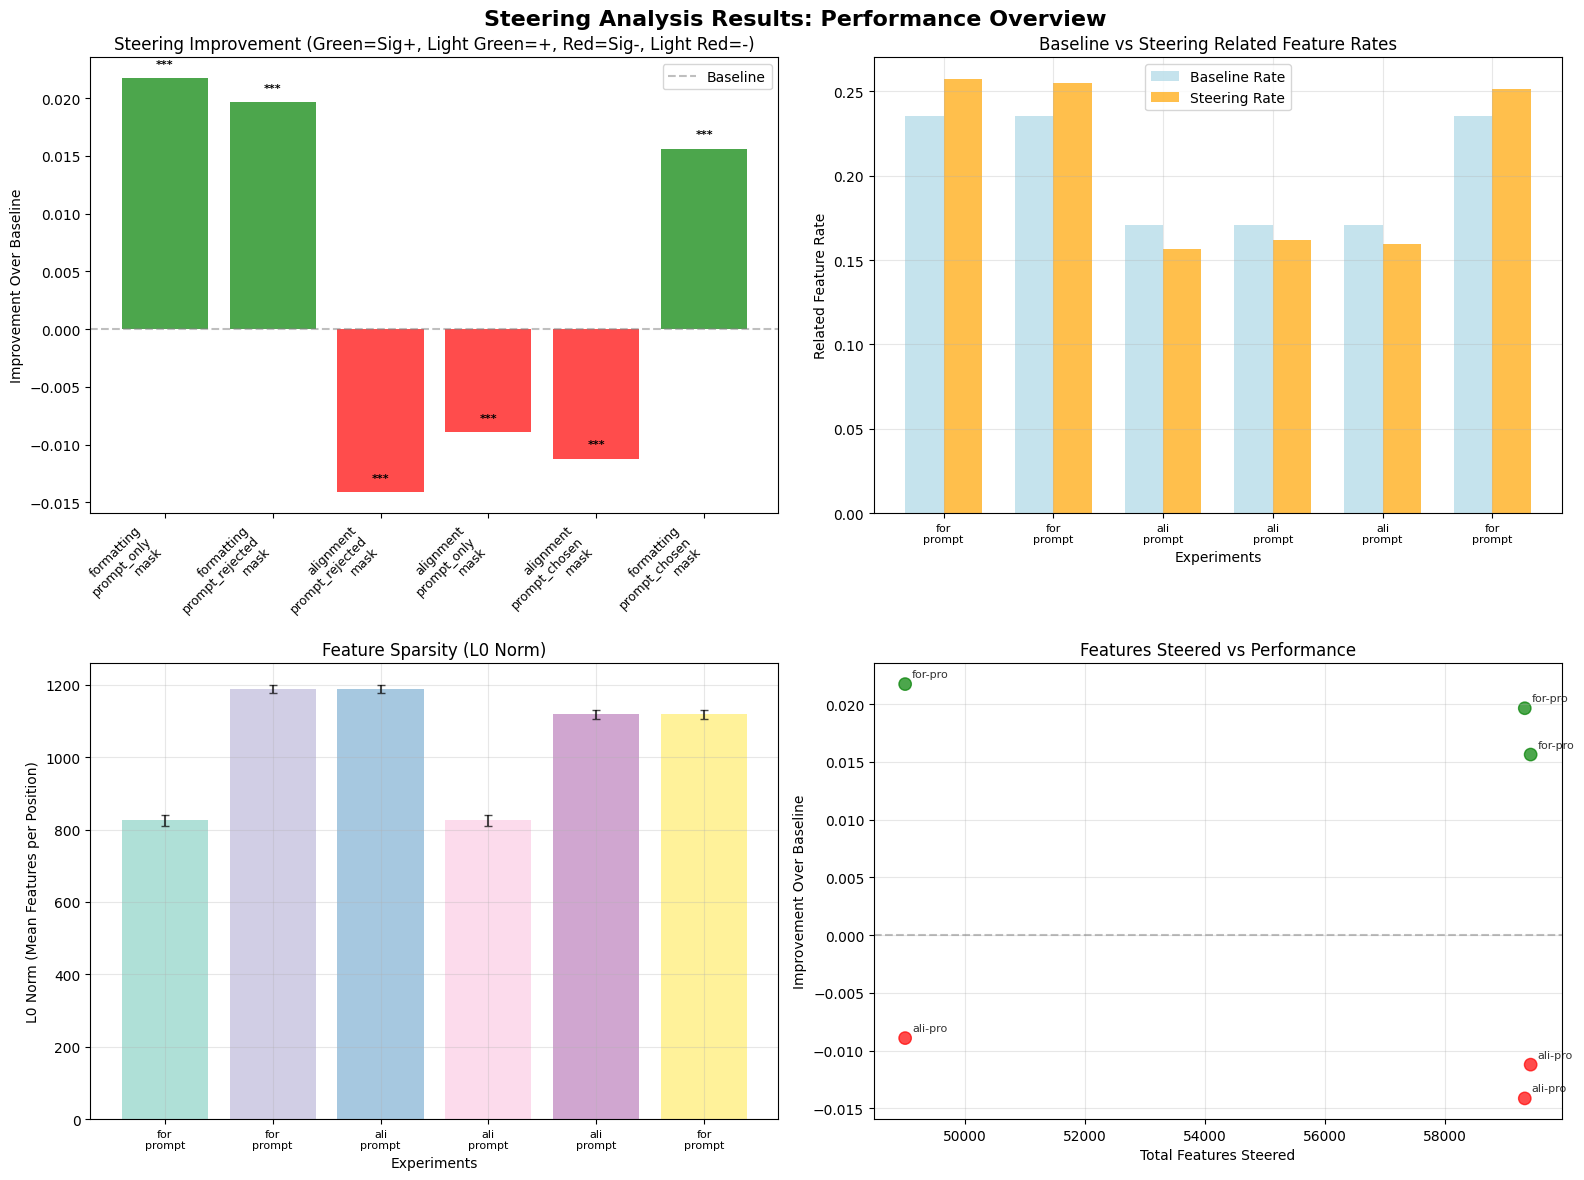


📈 STEERING ANALYSIS SUMMARY STATISTICS
Individual Experiment Results:
  • Total experiments: 6
  • Modes: formatting, alignment
  • Response types: prompt_only, prompt_rejected, prompt_chosen
  • Experiments with positive improvement: 3/6
  • Statistically significant improvements: 6/6

Overall Statistics Across All Experiments:
  • Mean improvement: 0.0038
  • Std improvement: 0.0169
  • Best improvement: 0.0217
  • Worst improvement: -0.0141

L0 Norm Statistics:
  • Mean L0 norm across experiments: 1043.99
  • Range of L0 norms: 825.47 - 1188.19
  • Mean internal std (within experiments): 393.12

Feature Steering Statistics:
  • Mean features steered per experiment: 55922.0
  • Range: 48996 - 59434 features
  • Mean related features steered: 11315.5

📋 EXPERIMENT SUMMARY:


,Mode,Response,Ignore Mask,Improvement,L0 Mean,L0 Std,Features Steered
0,formatting,prompt_only,True,0.0217,825.4655,457.6563,48996
1,formatting,prompt_rejected,True,0.0197,1188.1893,346.8941,59336
2,alignment,prompt_rejected,True,-0.0141,1188.1893,346.8941,59336
3,alignment,prompt_only,True,-0.0089,825.4655,457.6563,48996
4,alignment,prompt_chosen,True,-0.0112,1118.3045,374.8218,59434
5,formatting,prompt_chosen,True,0.0156,1118.3045,374.8218,59434



Overall Performance:
  • Mean improvement: 0.0038
  • Best improvement: 0.0217
  • Experiments with positive improvement: 3/6
  • Statistically significant improvements: 6/6


In [14]:
# Visualize Steering Performance
if len(df) > 0:
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Steering Analysis Results: Performance Overview', fontsize=16, fontweight='bold')
    
    # 1. Improvement Over Baseline by Experiment
    ax1 = axes[0, 0]
    df_plot = df.copy()
    if len(df_plot) > 0:
        # Color by significance and direction
        colors = []
        for _, row in df_plot.iterrows():
            if row['improvement_sig'] != '' and row['improvement_over_baseline'] > 0:
                colors.append('green')  # Significant positive
            elif row['improvement_over_baseline'] > 0:
                colors.append('lightgreen')  # Positive but not significant
            elif row['improvement_sig'] != '':
                colors.append('red')  # Significant negative
            else:
                colors.append('lightcoral')  # Negative but not significant
        
        x_labels = [f"{row['mode']}\n{row['response_type']}\n{'mask' if row['ignore_mask'] else 'no-mask'}" 
                   for _, row in df_plot.iterrows()]
        
        bars = ax1.bar(range(len(df_plot)), df_plot['improvement_over_baseline'], color=colors, alpha=0.7)
        ax1.set_xticks(range(len(df_plot)))
        ax1.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=9)
        ax1.set_ylabel('Improvement Over Baseline')
        ax1.set_title('Steering Improvement (Green=Sig+, Light Green=+, Red=Sig-, Light Red=-)')
        ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.5, label='Baseline')
        ax1.legend()
        
        # Add significance annotations
        for i, (_, row) in enumerate(df_plot.iterrows()):
            if row['improvement_sig']:
                ax1.annotate(row['improvement_sig'], (i, row['improvement_over_baseline'] + 0.001), 
                           ha='center', fontweight='bold', fontsize=8)
    
    # 2. Baseline vs Steering Rates
    ax2 = axes[0, 1]
    if len(df) > 0:
        x = np.arange(len(df))
        width = 0.35
        
        bars1 = ax2.bar(x - width/2, df['baseline_related_rate'], width, label='Baseline Rate', 
                       alpha=0.7, color='lightblue')
        bars2 = ax2.bar(x + width/2, df['steering_related_rate'], width, label='Steering Rate', 
                       alpha=0.7, color='orange')
        
        ax2.set_xlabel('Experiments')
        ax2.set_ylabel('Related Feature Rate')
        ax2.set_title('Baseline vs Steering Related Feature Rates')
        ax2.set_xticks(x)
        ax2.set_xticklabels([f"{row['mode'][:3]}\n{row['response_type'][:6]}" 
                            for _, row in df.iterrows()], fontsize=8)
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    
    # 3. L0 Norm Distribution
    ax3 = axes[1, 0]
    if len(df) > 0:
        # Create grouped bar chart by mode and response type
        modes = df['mode'].unique()
        response_types = df['response_type'].unique()
        
        x = np.arange(len(df))
        colors_l0 = plt.cm.Set3(np.linspace(0, 1, len(df)))
        
        bars = ax3.bar(x, df['l0_norm_mean'], color=colors_l0, alpha=0.7)
        
        # Add error bars
        ax3.errorbar(x, df['l0_norm_mean'], yerr=df['l0_norm_stderr'], 
                    fmt='none', color='black', capsize=3, alpha=0.7)
        
        ax3.set_xlabel('Experiments')
        ax3.set_ylabel('L0 Norm (Mean Features per Position)')
        ax3.set_title('Feature Sparsity (L0 Norm)')
        ax3.set_xticks(x)
        ax3.set_xticklabels([f"{row['mode'][:3]}\n{row['response_type'][:6]}" 
                            for _, row in df.iterrows()], fontsize=8)
        ax3.grid(True, alpha=0.3)
    
    # 4. Total Features Steered vs Improvement
    ax4 = axes[1, 1]
    if len(df) > 0:
        scatter_colors = ['green' if imp > 0 else 'red' for imp in df['improvement_over_baseline']]
        scatter = ax4.scatter(df['total_steered_features'], df['improvement_over_baseline'], 
                            c=scatter_colors, alpha=0.7, s=80)
        
        # Add labels for each point
        for i, (_, row) in enumerate(df.iterrows()):
            ax4.annotate(f"{row['mode'][:3]}-{row['response_type'][:3]}", 
                        (row['total_steered_features'], row['improvement_over_baseline']),
                        xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.8)
        
        ax4.set_xlabel('Total Features Steered')
        ax4.set_ylabel('Improvement Over Baseline')
        ax4.set_title('Features Steered vs Performance')
        ax4.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
        ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print("\n📈 STEERING ANALYSIS SUMMARY STATISTICS")
    print("=" * 50)
    
    if len(df) > 0:
        print(f"Individual Experiment Results:")
        print(f"  • Total experiments: {len(df)}")
        print(f"  • Modes: {', '.join(df['mode'].unique())}")
        print(f"  • Response types: {', '.join(df['response_type'].unique())}")
        print(f"  • Experiments with positive improvement: {(df['improvement_over_baseline'] > 0).sum()}/{len(df)}")
        print(f"  • Statistically significant improvements: {(df['improvement_sig'] != '').sum()}/{len(df)}")
        
        print(f"\nOverall Statistics Across All Experiments:")
        print(f"  • Mean improvement: {df['improvement_over_baseline'].mean():.4f}")
        print(f"  • Std improvement: {df['improvement_over_baseline'].std():.4f}")
        print(f"  • Best improvement: {df['improvement_over_baseline'].max():.4f}")
        print(f"  • Worst improvement: {df['improvement_over_baseline'].min():.4f}")
        
        print(f"\nL0 Norm Statistics:")
        print(f"  • Mean L0 norm across experiments: {df['l0_norm_mean'].mean():.2f}")
        print(f"  • Range of L0 norms: {df['l0_norm_mean'].min():.2f} - {df['l0_norm_mean'].max():.2f}")
        print(f"  • Mean internal std (within experiments): {df['l0_norm_std'].mean():.2f}")
        
        print(f"\nFeature Steering Statistics:")
        print(f"  • Mean features steered per experiment: {df['total_steered_features'].mean():.1f}")
        print(f"  • Range: {df['total_steered_features'].min()} - {df['total_steered_features'].max()} features")
        print(f"  • Mean related features steered: {df['related_steered'].mean():.1f}")
        
        # Show a simple table with key metrics per experiment
        print(f"\n📋 EXPERIMENT SUMMARY:")
        simple_summary = df[['mode', 'response_type', 'ignore_mask', 'improvement_over_baseline', 
                           'l0_norm_mean', 'l0_norm_std', 'total_steered_features']].copy()
        simple_summary.columns = ['Mode', 'Response', 'Ignore Mask', 'Improvement', 
                                 'L0 Mean', 'L0 Std', 'Features Steered']
        simple_summary = simple_summary.round(4)
        display(simple_summary)
        
        print(f"\nOverall Performance:")
        print(f"  • Mean improvement: {df['improvement_over_baseline'].mean():.4f}")
        print(f"  • Best improvement: {df['improvement_over_baseline'].max():.4f}")
        print(f"  • Experiments with positive improvement: {(df['improvement_over_baseline'] > 0).sum()}/{len(df)}")
        print(f"  • Statistically significant improvements: {(df['improvement_sig'] != '').sum()}/{len(df)}")
    
else:
    print("No data available for visualization.")

In [15]:
# Export Steering Analysis Results
if len(df) > 0:
    # Save comprehensive results
    output_dir = Path('../outputs/feature_classification/analysis')
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Export detailed results
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    # Full results with all columns
    full_results_file = output_dir / f'steering_analysis_detailed_results_{timestamp}.csv'
    df.to_csv(full_results_file, index=False)
    
    # Summary table
    summary_file = output_dir / f'steering_analysis_summary_table_{timestamp}.csv'
    final_table.to_csv(summary_file, index=False)
    
    # JSON summary for programmatic access
    json_summary = {
        'timestamp': timestamp,
        'total_experiments': len(df),
        'modes': df['mode'].value_counts().to_dict(),
        'response_types': df['response_type'].value_counts().to_dict(),
        'ignore_mask_usage': df['ignore_mask'].value_counts().to_dict(),
        'positive_improvements': (df['improvement_over_baseline'] > 0).sum(),
        'significant_improvements': (df['improvement_sig'] != '').sum(),
        'mean_improvement': float(df['improvement_over_baseline'].mean()),
        'best_experiment': {
            'improvement': float(df['improvement_over_baseline'].max()),
            'mode': df.loc[df['improvement_over_baseline'].idxmax(), 'mode'],
            'response_type': df.loc[df['improvement_over_baseline'].idxmax(), 'response_type'],
            'ignore_mask': bool(df.loc[df['improvement_over_baseline'].idxmax(), 'ignore_mask']),
            'steering_rate': float(df.loc[df['improvement_over_baseline'].idxmax(), 'steering_related_rate']),
            'baseline_rate': float(df.loc[df['improvement_over_baseline'].idxmax(), 'baseline_related_rate'])
        },
        'l0_norm_stats': {
            'mean': float(df['l0_norm_mean'].mean()),
            'std': float(df['l0_norm_std'].mean()),
            'min': float(df['l0_norm_mean'].min()),
            'max': float(df['l0_norm_mean'].max())
        },
        'feature_steering_stats': {
            'mean_total_steered': float(df['total_steered_features'].mean()),
            'mean_related_steered': float(df['related_steered'].mean()),
            'mean_positions_analyzed': float(df['total_positions_analyzed'].mean())
        }
    }
    
    json_file = output_dir / f'steering_analysis_summary_{timestamp}.json'
    with json_file.open('w') as f:
        json.dump(json_summary, f, indent=2, default=str)
    
    print(f"\n💾 STEERING ANALYSIS RESULTS EXPORTED")
    print(f"Full results: {full_results_file}")
    print(f"Summary table: {summary_file}")
    print(f"JSON summary: {json_file}")
    
    # Display key findings
    print(f"\n🎯 KEY FINDINGS:")
    best_exp = json_summary['best_experiment']
    print(f"Best Performance: {best_exp['improvement']:.4f} improvement")
    print(f"  • Mode: {best_exp['mode']}")
    print(f"  • Response: {best_exp['response_type']}")
    print(f"  • Ignore mask: {best_exp['ignore_mask']}")
    print(f"  • Steering rate: {best_exp['steering_rate']:.3f} ({best_exp['steering_rate']*100:.1f}%)")
    print(f"  • Baseline rate: {best_exp['baseline_rate']:.3f} ({best_exp['baseline_rate']*100:.1f}%)")
    
    print(f"\nOverall Summary:")
    print(f"  • {json_summary['positive_improvements']}/{json_summary['total_experiments']} experiments show positive improvement")
    print(f"  • {json_summary['significant_improvements']}/{json_summary['total_experiments']} experiments are statistically significant")
    print(f"  • Mean improvement across all experiments: {json_summary['mean_improvement']:.4f}")
    print(f"  • Mean L0 norm: {json_summary['l0_norm_stats']['mean']:.2f} features per position")
    
else:
    print("\n⚠️  No results to export. Run steering analysis experiments first.")


💾 STEERING ANALYSIS RESULTS EXPORTED
Full results: ../outputs/feature_classification/analysis/steering_analysis_detailed_results_20250819_121757.csv
Summary table: ../outputs/feature_classification/analysis/steering_analysis_summary_table_20250819_121757.csv
JSON summary: ../outputs/feature_classification/analysis/steering_analysis_summary_20250819_121757.json

🎯 KEY FINDINGS:
Best Performance: 0.0217 improvement
  • Mode: formatting
  • Response: prompt_only
  • Ignore mask: True
  • Steering rate: 0.257 (25.7%)
  • Baseline rate: 0.236 (23.6%)

Overall Summary:
  • 3/6 experiments show positive improvement
  • 6/6 experiments are statistically significant
  • Mean improvement across all experiments: 0.0038
  • Mean L0 norm: 1043.99 features per position


In [25]:
# Create LaTeX Table for Report
if len(df) > 0:
    # Function to format labels nicely
    def format_mode_label(mode):
        """Format mode labels for display."""
        if mode == 'alignment':
            return 'Alignment'
        elif mode == 'formatting':
            return 'Formatting'
        else:
            return mode.title()
    
    def format_response_label(response_type):
        """Format response type labels for display."""
        if response_type == 'prompt_only':
            return 'Prompt Only'
        elif response_type == 'prompt_chosen':
            return 'Prompt + Chosen'
        elif response_type == 'prompt_rejected':
            return 'Prompt + Rejected'
        else:
            return response_type.replace('_', ' ').title()
    
    def format_pvalue(p_value):
        """Format p-value for display with higher precision."""
        if p_value is None or pd.isna(p_value):
            return 'N/A'
        elif p_value < 1e-15:
            return '$<10^{-15}$'
        elif p_value < 1e-10:
            return f'${p_value:.2e}$'
        elif p_value < 1e-6:
            return f'${p_value:.1e}$'
        elif p_value < 0.0001:
            return f'${p_value:.6f}$'
        elif p_value < 0.001:
            return f'${p_value:.4f}$'
        elif p_value < 0.01:
            return f'${p_value:.3f}$'
        else:
            return f'${p_value:.3f}$'
    
    def calculate_baseline_se(baseline_rate, n_positions):
        """Calculate standard error for baseline rate."""
        if n_positions <= 0:
            return None
        return np.sqrt(baseline_rate * (1 - baseline_rate) / n_positions)
    
    def calculate_improvement_se(baseline_rate, steering_rate, n_positions):
        """Calculate standard error for improvement."""
        if n_positions <= 0:
            return None
        baseline_var = baseline_rate * (1 - baseline_rate) / n_positions
        steering_var = steering_rate * (1 - steering_rate) / n_positions
        se_diff = np.sqrt(baseline_var + steering_var)
        return se_diff
    
    # First, let's examine the data to understand sample sizes and p-values
    print("🔍 DATA INSPECTION:")
    print("=" * 50)
    print("Sample sizes (total_positions_analyzed):")
    print(df[['mode', 'response_type', 'total_positions_analyzed']].to_string(index=False))
    
    # Debug the statistical calculations
    print(f"\nDetailed Statistical Analysis (using Binomial Test):")
    for _, row in df.iterrows():
        improvement = row['improvement_over_baseline']
        n = row['total_positions_analyzed']
        baseline = row['baseline_related_rate']
        steering = row['steering_related_rate']
        
        # Calculate what was tested
        steering_successes = int(round(steering * n))
        expected_successes = baseline * n
        
        print(f"\n  {row['mode']}-{row['response_type']}:")
        print(f"    Improvement: {improvement:.8f}")
        print(f"    Sample size: {n:,}")
        print(f"    Baseline rate: {baseline:.6f} (expected: {expected_successes:.0f} successes)")
        print(f"    Steering rate: {steering:.6f} (observed: {steering_successes} successes)")
        print(f"    Difference: {steering_successes - expected_successes:.0f} successes")
        print(f"    P-value (binomial): {row['improvement_pvalue']:.2e}")
    
    print(f"\nP-values range: {df['improvement_pvalue'].min():.2e} to {df['improvement_pvalue'].max():.2e}")
    print(f"Improvements range: {df['improvement_over_baseline'].min():.6f} to {df['improvement_over_baseline'].max():.6f}")
    
    # Create the LaTeX table with booktabs and multicolumn formatting
    print(f"\n📋 CREATING FANCY LATEX TABLE WITH BOOKTABS:")
    print("=" * 100)
    
    print(f"\n📄 LATEX TABLE CODE:")
    print("=" * 100)
    
    # Create a fancy booktabs LaTeX table with multicolumn headers
    latex_lines = []
    
    # Table header
    latex_lines.append("\\begin{table}[htbp]")
    latex_lines.append("\\centering")
    latex_lines.append("\\caption{Steering Analysis Results: Relative change over baseline rates. Relative change shows the percentage increase or decrease from baseline. Improvement column: $\\checkmark$ indicates positive change, $\\times$ indicates negative change.}")
    latex_lines.append("\\label{tab:steering_results}")
    latex_lines.append("\\begin{tabular}{lccc}")
    latex_lines.append("\\toprule")
    latex_lines.append("Response Type & Baseline Rate (\\%) & Relative Change (\\%) & Improvement \\\\")
    latex_lines.append("\\midrule")
    
    # Process data by mode groups
    for mode in sorted(df['mode'].unique()):
        mode_data = df[df['mode'] == mode].copy()
        mode_data = mode_data.sort_values('response_type')
        
        # Get baseline rate for this mode
        baseline_rate = mode_data['baseline_related_rate'].iloc[0]
        baseline_se = calculate_baseline_se(baseline_rate, mode_data['total_positions_analyzed'].iloc[0])
        
        if baseline_se is not None:
            baseline_formatted = f"{baseline_rate*100:.2f} $\\pm$ {baseline_se*100:.2f}"
        else:
            baseline_formatted = f"{baseline_rate*100:.2f}"
        
        # Add mode header with multicolumn
        mode_label = format_mode_label(mode)
        latex_lines.append(f"\\multicolumn{{4}}{{l}}{{\\textbf{{{mode_label}}}}} \\\\")
        latex_lines.append("\\midrule")
        
        # Add response type rows with baseline in separate column
        for idx, (_, row) in enumerate(mode_data.iterrows()):
            improvement_se = calculate_improvement_se(
                row['baseline_related_rate'], 
                row['steering_related_rate'], 
                row['total_positions_analyzed']
            )
            
            relative_improvement = row['improvement_over_baseline'] / row['baseline_related_rate'] if row['baseline_related_rate'] > 0 else 0
            
            if improvement_se is not None and row['baseline_related_rate'] > 0:
                relative_improvement_se = improvement_se / row['baseline_related_rate']
                improvement_formatted = f"{relative_improvement*100:.2f} $\\pm$ {relative_improvement_se*100:.2f}"
            else:
                improvement_formatted = f"{relative_improvement*100:.2f}"
            
            response_label = format_response_label(row['response_type'])
            improvement_symbol = '$\\checkmark$' if row['improvement_over_baseline'] > 0 else '$\\times$'
            
            # Show baseline in the middle row of each mode group
            middle_idx = len(mode_data) // 2
            if idx == middle_idx:
                baseline_display = baseline_formatted
            else:
                baseline_display = ""
            
            latex_lines.append(f"{response_label} & {baseline_display} & {improvement_formatted} & {improvement_symbol} \\\\")
        
        # Add spacing between modes
        latex_lines.append("\\addlinespace")
    
    # Table footer
    latex_lines.append("\\bottomrule")
    latex_lines.append("\\end{tabular}")
    latex_lines.append("\\end{table}")
    
    latex_table = "\n".join(latex_lines)
    
    print(latex_table)
    
    # Save to file
    output_dir = Path('../outputs/feature_classification/analysis')
    latex_file = output_dir / f'steering_analysis_latex_table_{datetime.now().strftime("%Y%m%d_%H%M%S")}.tex'
    with latex_file.open('w') as f:
        f.write(latex_table)
    
    print(f"\n💾 LaTeX table saved to: {latex_file}")

else:
    print("\n⚠️  No results available for LaTeX table generation.")

print(latex_table)

🔍 DATA INSPECTION:
Sample sizes (total_positions_analyzed):
      mode   response_type  total_positions_analyzed
formatting     prompt_only                    467682
formatting prompt_rejected                   1496692
 alignment prompt_rejected                   1496692
 alignment     prompt_only                    467682
 alignment   prompt_chosen                   1445875
formatting   prompt_chosen                   1445875

Detailed Statistical Analysis (using Binomial Test):

  formatting-prompt_only:
    Improvement: 0.02174168
    Sample size: 467,682
    Baseline rate: 0.235538 (expected: 110157 successes)
    Steering rate: 0.257280 (observed: 120325 successes)
    Difference: 10168 successes
    P-value (binomial): 1.42e-263

  formatting-prompt_rejected:
    Improvement: 0.01965101
    Sample size: 1,496,692
    Baseline rate: 0.235538 (expected: 352528 successes)
    Steering rate: 0.255189 (observed: 381939 successes)
    Difference: 29411 successes
    P-value (binomial):